# aiReview

aiReview is an artificial intelligence-based system that creates a reviewer (in the form of an HTML file) from handwritten lecture notes. It uses optical character recognition (OCR) in converting an image of handwritten text into a machine-readable text file. Unlike other OCR software, it also features an annotation-conversion system that converts underlined words in the input with blanks and encircled words into bolded words.

This project is developed by: 

- A.V. Cayetano (THX)
- J. M. Choa (THX)
- H. A. Macalisang (THU)
- R. J. Portuguez (THW)

Thematic inspiration:
SDG 4 – Quality Education.

## Import packages

In [9]:
import numpy as np
import pandas as pd
import scipy
import cv2
from matplotlib import pyplot as plt
import ipynb.fs.defs.utils as utils
from PIL import Image
from IPython.display import display
from scipy.ndimage import interpolation

## Methodology

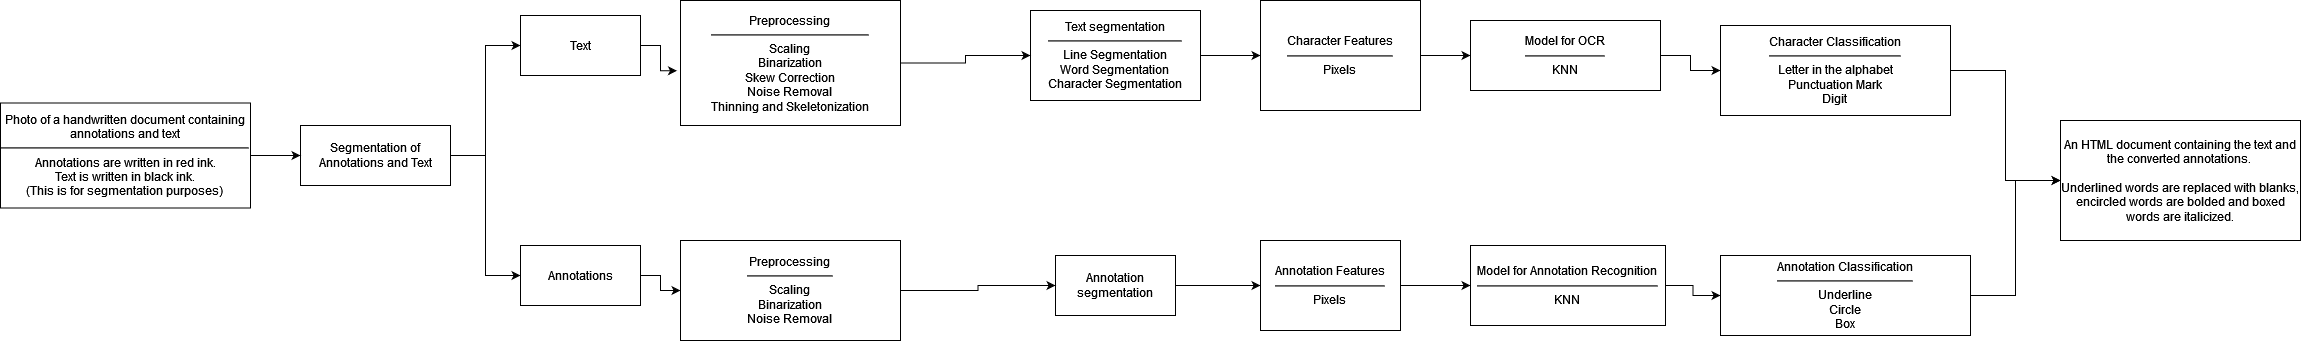

In [10]:
with Image.open("../media/method.png") as method_img:
    display(method_img)
    
    

# The image below is not updated. Will update soon.
 


## Load Data

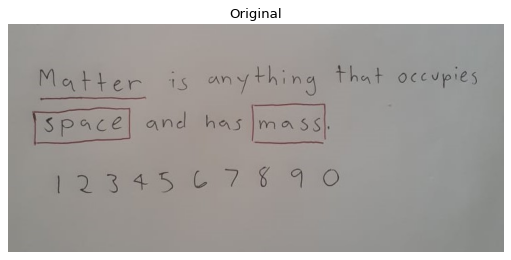

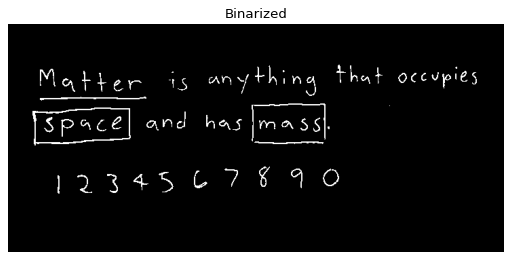

In [14]:
# load dataset here



# load test data here
# test_img = cv2.imread("../input/test_3.png")
test_img = cv2.imread("../input/test_4.png") # try this for more realistic image

test_img_gs = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
_, test_img_bin = cv2.threshold(test_img_gs, 127, 255, cv2.THRESH_BINARY_INV)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
utils.plot_img_rgb(test_img_rgb, "Original")
# utils.plot_img_rgb(cv2.cvtColor(test_img_gs, cv2.COLOR_GRAY2RGB), "")
utils.plot_img_rgb(cv2.cvtColor(test_img_bin, cv2.COLOR_GRAY2RGB), "Binarized")

## Segmentation of Annotations and Text and Noise Removal

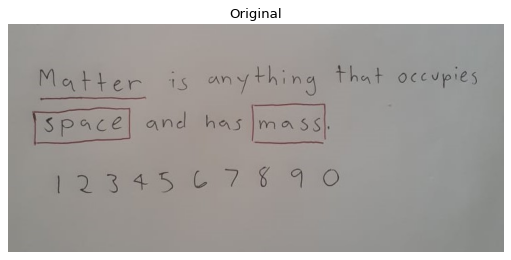

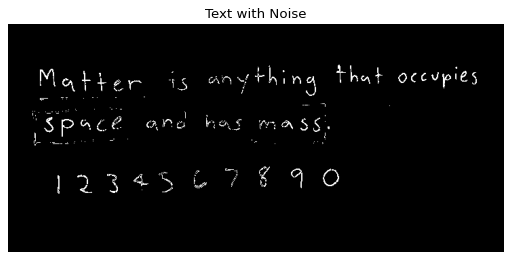

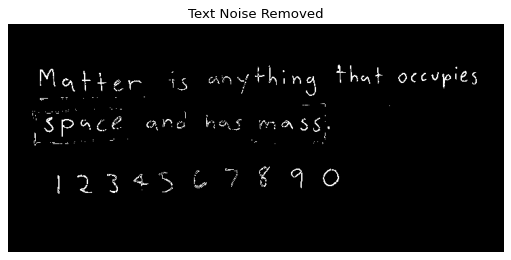

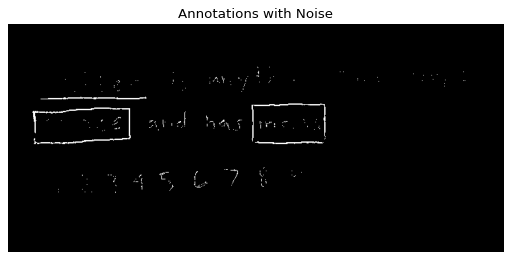

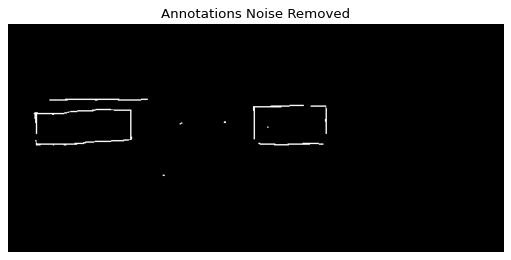

In [15]:
# References:
# https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html
# https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

# This function uses masks to segment
def get_text(test_img):
    # filter all black inks
     # problem: we need to find the appropriate values for these limits
    lower_text_color = np.array([0, 0, 0])
    upper_text_color = np.array([179, 44, 130])
    text_img = cv2.inRange(test_img, lower_text_color, upper_text_color)

    return text_img

def remove_noise(text_img_bin, kernel_size_open=(1, 1), kernel_size_close=(1, 1)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)
    text_img_bin = cv2.morphologyEx(text_img_bin, cv2.MORPH_OPEN, kernel_open)
    text_img_bin = cv2.morphologyEx(text_img_bin, cv2.MORPH_CLOSE, kernel_close)
    
    return text_img_bin


def get_annotations(test_img_bin, text_img_bin):
    # filter all inks that are not text
    annotations_img = cv2.bitwise_xor(test_img_bin, text_img_bin)
    return annotations_img

utils.plot_img_rgb(test_img_rgb, "Original")

text_img_bin = get_text(test_img_hsv)

utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text with Noise")

text_img_bin = remove_noise(text_img_bin)


utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text Noise Removed")

annotations_img_bin = get_annotations(test_img_bin, text_img_bin)

utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations with Noise")

annotations_img_bin = remove_noise(annotations_img_bin, (2, 2), (8, 8))



utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations Noise Removed")


## Skew Correction

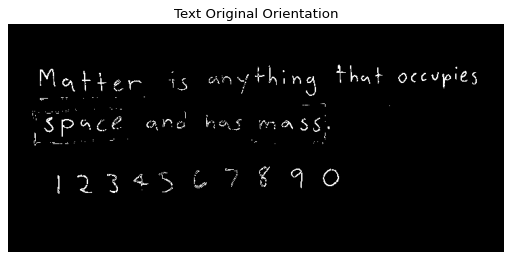

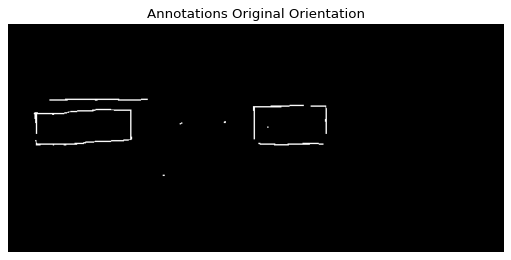

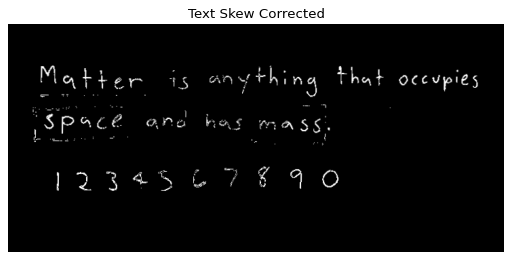

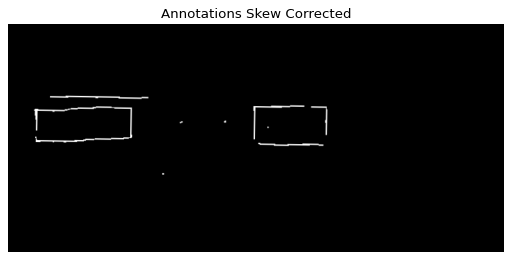

In [16]:
# References:
# https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
# https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html

utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text Original Orientation")
utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations Original Orientation")

coords = np.column_stack(np.where(text_img_bin > 0))
angle = cv2.minAreaRect(coords)[-1]

if angle > 45:
    angle = 90 - angle
else:
    angle = -angle

rows, cols = text_img_bin.shape
rotation = cv2.getRotationMatrix2D((cols//2, rows//2), angle, 1)
text_img = cv2.warpAffine(text_img_bin, rotation, (cols, rows))
annotations_img = cv2.warpAffine(annotations_img_bin, rotation, (cols, rows))


utils.plot_img_rgb(cv2.cvtColor(text_img, cv2.COLOR_GRAY2RGB), "Text Skew Corrected")
utils.plot_img_rgb(cv2.cvtColor(annotations_img, cv2.COLOR_GRAY2RGB), "Annotations Skew Corrected")

## Text Segmentation

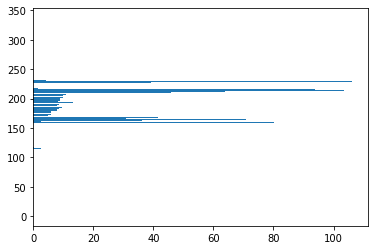

In [40]:
def hhp(img):
    horizontal_hist = np.sum(img,axis=1,keepdims=True)/255
    y = [x for x in range(len(horizontal_hist),0,-1)]
    x = []
    for f in horizontal_hist:
        for g in f:
            x.append(g)
    plt.barh(y, x)
    
hhp(annotations_img)


## Annotations Segmentation